# **PHASE 1 : TRAITEMENT DES IMAGES**

# **1 - Importation des bibliothèques**

In [29]:
import cv2 # pour afficher les images
import pandas as pd # pour manipuler les fichiers csv
import numpy as np # bibliothèque de l'algèbre linéaire
import matplotlib.pyplot as plt # pour le traçage des graphes
from matplotlib.colors import ListedColormap
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split # pour fractionner les données
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pour traiter les images


# **2 - Préparation des données**

In [30]:
csv_path = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv' 
train_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/' 
test_path = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

In [31]:
data = pd.read_csv(csv_path) # pour accéder au fichier csv
Train = data[data['Dataset_type'] == 'TRAIN'] # les données d'entrainement
Train = Train[['X_ray_image_name', 'Label']] 
Test = data[data['Dataset_type'] == 'TEST'] # les données de prédiction
Test = Test[['X_ray_image_name', 'Label']]
Train, Valid = train_test_split(Train, test_size=0.2, stratify=Train['Label'], random_state=38) # les données d'entrainement et de validation

In [32]:
Generator_1 = ImageDataGenerator(rescale=1/255.)
Generator_2 = ImageDataGenerator(rescale = 1./255,
                                width_shift_range = 0.15,
                                height_shift_range = 0.15,
                                zoom_range = [0.9, 1.25],
                                brightness_range = [0.5, 1.5]
                                )  
targetSize = (224, 224) # la taille commune sera 224x224
batchSize = 32 # pour regrouper les images (32 images par groupe)
classMode = 'binary' # nous avons deux classes : 0 et 1
colorMode = 'rgb'  # rgb pour red/green/blue , 3 dimensions

Final_Train = Generator_2.flow_from_dataframe(
    dataframe = Train,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True # reorganniser les images 
    )

Final_Valid = Generator_1.flow_from_dataframe(
    dataframe = Valid,
    directory = train_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Final_Test = Generator_1.flow_from_dataframe(
    dataframe = Test,
    directory = test_path,
    x_col = 'X_ray_image_name',
    y_col = 'Label',
    target_size = targetSize, 
    batch_size = batchSize,
    class_mode = classMode, 
    color_mode = colorMode,
    shuffle = True
    )

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# **PHASE 2 : ENTRAINEMENT**

# **1 - Importation des bibliothèques**

In [33]:
# Pour l'apprentissage profond
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as tf_hub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **2 - Le choix des métriques**

In [34]:
metrics = ['accuracy',keras.metrics.Precision(name='precision')]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

# **3 - Le modèle EfficientNet V2 B0 amélioré**

In [35]:
tf.random.set_seed(38)

efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'

feature_extractor_layer = tf_hub.KerasLayer(efficientnetv2_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224, 224, 3,))

efficientnet_model_improved = tf.keras.Sequential([
                                feature_extractor_layer,

                                tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Dense(256),
                                tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Activation('relu'),
                                tf.keras.layers.Dropout(0.5),

                                tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')     
                                ])

efficientnet_model_improved.compile(loss='binary_crossentropy',
                                  optimizer=Adam(5e-4),
                                  metrics=metrics)

efficientnet_model_improved.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                

In [36]:
efficientnet_improved_history = efficientnet_model_improved.fit(Final_Train,
                                              epochs = 30, 
                                              validation_data = Final_Valid,
                                              steps_per_epoch = len(Final_Train),
                                              validation_steps = len(Final_Valid),
                                              callbacks = callbacks)

Epoch 1/30
133/133 [==============================] - 112s 802ms/step - loss: 0.2382 - accuracy: 0.9044 - precision: 0.9565 - val_loss: 0.1815 - val_accuracy: 0.9509 - val_precision: 0.9780
Epoch 2/30
133/133 [==============================] - 105s 792ms/step - loss: 0.1476 - accuracy: 0.9435 - precision: 0.9634 - val_loss: 0.1602 - val_accuracy: 0.9499 - val_precision: 0.9907
Epoch 3/30
133/133 [==============================] - 107s 802ms/step - loss: 0.1219 - accuracy: 0.9515 - precision: 0.9683 - val_loss: 0.1748 - val_accuracy: 0.9367 - val_precision: 0.9945
Epoch 4/30
133/133 [==============================] - 104s 784ms/step - loss: 0.1237 - accuracy: 0.9525 - precision: 0.9680 - val_loss: 0.1110 - val_accuracy: 0.9641 - val_precision: 0.9883
Epoch 5/30
133/133 [==============================] - 104s 780ms/step - loss: 0.1114 - accuracy: 0.9529 - precision: 0.9701 - val_loss: 0.1120 - val_accuracy: 0.9631 - val_precision: 0.9921
Epoch 6/30
133/133 [==============================

In [37]:
efficientnet_model_improved.save("EfficientNet_V2_B0_Improved.h5")

# **PHASE 3 : EVALUATION ET PREDICTION**

# **1 - La courbe d'apprentissage**

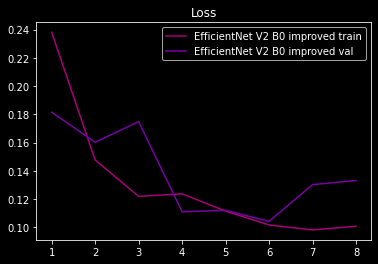

In [38]:
loss = efficientnet_improved_history.history.get('loss')
val_loss = efficientnet_improved_history.history.get('val_loss')
epochs = np.arange(1, len(efficientnet_improved_history.history.get('loss')) + 1)

plt.plot(epochs, loss, color = '#a9007a')
plt.plot(epochs, val_loss, color = '#7900a5')
plt.legend(("EfficientNet V2 B0 improved train", "EfficientNet V2 B0 improved val"))
plt.title('Loss')
plt.show()

# **2 - La matrice de confusion**

In [48]:
i=0
y_true = []
for l in Final_Test:
    i+=1
    for x in l[1]:
        y_true.append(x)
    if i>=len(Final_Test):
        break

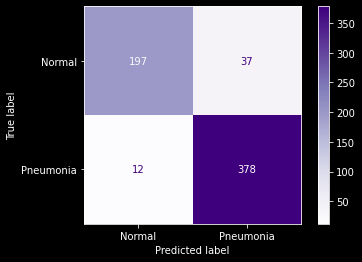

In [49]:
Final_Test.reset()

labels = ["Normal", "Pneumonia"]

efficientnet_improved_predictions = efficientnet_model_improved.predict(Final_Test)
y_pred = [1 if i > 0.75 else 0 for i in efficientnet_improved_predictions]

efficientnet_improved_matrix = confusion_matrix(y_true, y_pred)
efficientnet_improved_disp = ConfusionMatrixDisplay(confusion_matrix=efficientnet_improved_matrix, display_labels=labels)
efficientnet_improved_disp.plot(cmap=plt.cm.Purples)
plt.show()

# **2 - Les scores**

In [41]:
Final_Test.reset()
score = efficientnet_model_improved.evaluate(Final_Test) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

20/20 [==============================] - 6s 288ms/step - loss: 0.2895 - accuracy: 0.9071 - precision: 0.8790
Test loss: 0.28947389125823975
Test accuracy: 0.9070512652397156
